# KdV Uncertainty output

## Plots

Produce the following plots:
 - Example a0 and density profiles for one time step
 - Example of a time-series all A(t) for 1, 10, 500 runs
 - Timeseries of 'max_amplitude' all runs
 - Timeseries of normalized 'max_amplitude' all runs
 
---
Other plots for the paper/talks:
 - *Example of scenario A(x,t)* requires running a simulation...

In [115]:
import h5py
from glob import glob


from dask import array as da
from dask import delayed

import matplotlib.pyplot as plt
%matplotlib notebook

# Test loading some data

Data are stored in individual hdf5 files for each step (1473) and each sample (500)

In [128]:
sorted(glob("shiny_dashboard/data/timepoint-1/all_amplitudes/*.h5"))

def get_file_name(timepoint, sample):
    return "shiny_dashboard/data/timepoint-%d/all_amplitudes/2018-07-24--13-00-34_timepoint-%d_sample-%d_output.h5"%(timepoint,timepoint,sample)

get_file_name(1,0)

'shiny_dashboard/data/timepoint-1/all_amplitudes/2018-07-24--13-00-34_timepoint-1_sample-0_output.h5'

In [129]:
h5 = h5py.File(get_file_name(1,0),'r')
list(h5.keys())

['a0_sample',
 'amplitudes',
 'beta_samples',
 'max_amplitude',
 'sample',
 'timepoint']

In [118]:
h5['a0_sample'].value

5.395666138530389

In [119]:
h5['beta_samples'][:]

array([1023.43542536,    1.26678955,   60.79655458,   24.98486602,
        141.5239436 ,   44.09018998])

In [120]:
h5['max_amplitude'].value

-5.94777680902352

In [121]:
h5['amplitudes'].shape

(6480,)

# Data loading tools

In [130]:
@delayed(nout=1)
def load_h5_step(varname, timepoint):
    nsamples = 500

    a0 = []
    for ii in range(nsamples):
        h5 = h5py.File(get_file_name(timepoint,ii),'r')
        a0.append(da.from_array( h5[varname].value, chunks=-1))
        h5.close()

    a0_da = da.stack(a0)

    return a0_da

@delayed(nout=1)
def load_h5_alltime(varname, maxpoints):

    a0 = []
    for ii in range(maxpoints):
        a0_da = load_h5_step(varname, ii)
        a0.append(a0_da)
        
    #a0_t = da.stack(a0, axis=0)
    
    return a0

        
#amp, beta, a0 = load_h5_step(1)

In [123]:
a0 = load_h5_step('a0_sample',10)
#a0 = load_h5_step('beta_samples',10)

#a0 = load_h5_alltime('beta_samples',10)

a0.compute()

Delayed('load_h5_step-2a25ca3c-ffe1-46b0-9d14-e4486e15219d')

# Plot of some initial conditions for one scenario

Text(0.5,0,'Count')

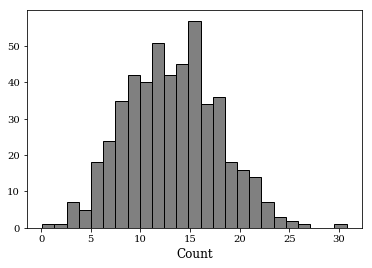

In [133]:
plt.hist(a0.compute(),bins=25, color='0.5', edgecolor='k')
plt.xlabel('$a_0$ [m]')
plt.xlabel('Count')

In [111]:
out

(Delayed('load_h5_step-6ce176db-7e12-4bb8-b633-410275438125'),)

In [62]:
delayed?